# EE 277 Machine Exercise 1
Romelio P. Tavas Jr.<br/>
2011-11218

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from queue import PriorityQueue

# Read input file

In [2]:
f = open('EE277_ME1_file2compress.txt')
input_text = f.read()
print(input_text[:400])

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus condimentum sagittis lacus, laoreet luctus ligula laoreet ut. Vestibulum ullamcorper accumsan velit vel vehicula. Proin tempor lacus arcu. Nunc at elit condimentum, semper nisi et, condimentum mi. In venenatis blandit nibh at sollicitudin. Vestibulum dapibus mauris at orci maximus pellentesque. Nullam id elementum ipsum. Suspendisse 


# Estimate the probability of each symbol in the text

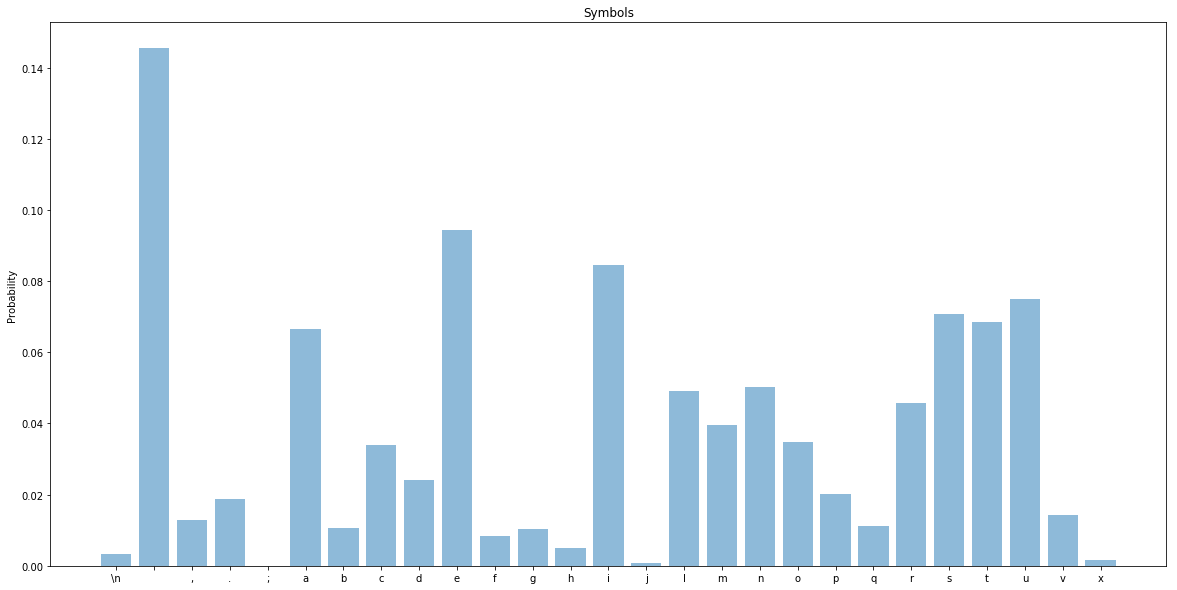

In [3]:
def calc_symbol_prob(text):
    text_len = len(text)
    splitted = [s.lower() for s in list(text)]
    d = {}
    
    for s in splitted:
        if s not in d:
            d[s] = 1
        else:
            d[s] += 1
    
    for k in d.keys():
        d[k] = d[k] / text_len 
    
    return d
    

symbol_prob = calc_symbol_prob(input_text)

symbols = list(symbol_prob.keys())
symbols.sort()
symbol_xticks = ['\\n' if k == '\n' else k for k in symbols]

probabilities = [symbol_prob[s] for s in symbols]
x = np.arange(len(symbols))
plt.figure(figsize=(20,10))
plt.bar(x, probabilities, align='center', alpha=0.5)
plt.xticks(x, symbol_xticks)
plt.ylabel('Probability')
plt.title('Symbols')
plt.savefig('EE277_ME1_frequencyplot.png')
plt.show()

# Assign a binary codeword for each symbol using Huffman Encoding

In [4]:
pq = PriorityQueue()
codewords = {}

# Add symbol probability and symbol array tuple to Priority Queue
for s in symbols:
    queue_elem = (symbol_prob[s], [s])
    pq.put(queue_elem)
    codewords[s] = ''
    
while not pq.qsize() == 1:
    # s1 is least, s2 is second least
    s1 = pq.get()
    s2 = pq.get()
    
    # Prepend bit '1' to least symbol
    for symbol in s1[1]:
        codewords[symbol] = '1'+ codewords[symbol]
    
    # Prepend bit '0' to second least symbol
    for symbol in s2[1]:
        codewords[symbol] = '0' + codewords[symbol]
    # Calculate new probability for combined symbol
    new_prob = s1[0] + s2[0]
    new_symbols = s1[1] + s2[1]
    s3 = (new_prob, new_symbols)
    pq.put(s3)


    
with open('EE277_ME1_codewordassignment.txt', 'w+') as output:
    keys = list(codewords.keys())
    symbol_probs = [(symbol_prob[s], s) for s in symbols]
    symbol_probs.sort(key=lambda x : x[0], reverse=True)
    for sp in symbol_probs:
        symbol = '\\n' if sp[1] == '\n' else sp[1]
        sym_to_cw = symbol + " : " + codewords[sp[1]]
        print(sym_to_cw)
        output.write(sym_to_cw + '\n')

  : 010
e : 110
i : 0000
u : 0010
s : 0011
t : 0110
a : 1000
n : 1010
l : 1011
r : 1110
m : 00010
o : 01110
c : 01111
d : 10011
p : 000110
. : 100100
v : 100101
, : 111100
q : 111101
b : 111111
g : 0001110
f : 0001111
h : 1111101
\n : 11111000
x : 111110010
j : 1111100110
; : 1111100111


# Compress File using Huffman Coded Codewords

In [5]:
def encode_str(input_text, codewords):
    input_ch_array = [s.lower() for s in list(input_text)]
    encoded_str = ''
    for ch in input_ch_array:
        encoded_str += codewords[ch]
    return encoded_str

def pad_encoded_str(encoded_str):
    extra_padding = 8 - len(encoded_str) % 8
    for i in range(extra_padding):
        encoded_str += '0'

    padded_info = '{0:08b}'.format(extra_padding)
    encoded_str = padded_info + encoded_str

    return encoded_str

def get_byte_array(padded_encoded_str):
    b = bytearray()
    for i in range(0, len(padded_encoded_str), 8):
        byte = padded_encoded_str[i:i+8]
        b.append(int(byte, 2))
    return b


with open('EE277_ME1_encoder_out.txt', 'wb') as output:
    # Encode input_text using the calculated codewords from Huffman encoding
    encoded_str = encode_str(input_text, codewords)
    
    # Pad encoded string so we can write to binary file as bytes (8 bit)
    padded_encoded_str = pad_encoded_str(encoded_str)
    # Get the bitstring's byte array representation
    encoding_byte_array = get_byte_array(padded_encoded_str)
    # Write byte array to a binary file
    output.write(bytes(encoding_byte_array))
    print('Output file written to: EE277_ME1_encoder_out.txt')


Output file written to: EE277_ME1_encoder_out.txt


# Decode compressed file

In [6]:
codeword_to_symbol = {v: k for k, v in codewords.items()}

def remove_padding(bit_str):
    padded_info = bit_str[:8]
    extra_padding = int(padded_info, 2)

    padded_encoded_str = bit_str[8:] 
    encoded_str = padded_encoded_str[:-1*extra_padding]

    return encoded_str

def decode_str(encoded_str, codeword_to_symbol):
    decoded = ''
    temp = ''
    
    for s in encoded_str:
        temp += s
        if temp in codeword_to_symbol:
            decoded += codeword_to_symbol[temp]
            temp = ''
    return decoded

def decompress_file(filename, codeword_to_symbol):
    file = open(filename, 'rb')
    bit_str = ""

    byte = file.read(1)
    while(len(byte) > 0):
        byte = ord(byte)
        bits = bin(byte)[2:].rjust(8, '0')
        bit_str += bits
        byte = file.read(1)
    file.close()
    
    encoded_str = remove_padding(bit_str)
    decompressed_str = decode_str(encoded_str, codeword_to_symbol)
    
    print("Decompressed: \n")
    print(decompressed_str)
    output = open('EE277_ME1_decoder_out.txt', 'w')
    output.write(decompressed_str)
    output.close()
    
decompress_file('EE277_ME1_encoder_out.txt', codeword_to_symbol)


Decompressed: 

lorem ipsum dolor sit amet, consectetur adipiscing elit. vivamus condimentum sagittis lacus, laoreet luctus ligula laoreet ut. vestibulum ullamcorper accumsan velit vel vehicula. proin tempor lacus arcu. nunc at elit condimentum, semper nisi et, condimentum mi. in venenatis blandit nibh at sollicitudin. vestibulum dapibus mauris at orci maximus pellentesque. nullam id elementum ipsum. suspendisse cursus lobortis viverra. proin et erat at mauris tincidunt porttitor vitae ac dui.

donec vulputate lorem tortor, nec fermentum nibh bibendum vel. lorem ipsum dolor sit amet, consectetur adipiscing elit. praesent dictum luctus massa, non euismod lacus. pellentesque condimentum dolor est, ut dapibus lectus luctus ac. ut sagittis commodo arcu. integer nisi nulla, facilisis sit amet nulla quis, eleifend suscipit purus. class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. aliquam euismod ultrices lorem, sit amet imperdiet est tincidunt vel. ph